In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import joblib

# NLP (Natural Language Processing) Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK data (only needs to be done once)
nltk.download('stopwords')

print("Libraries Imported Successfully")

Libraries Imported Successfully


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srirammuvva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Load the dataset with robust settings
print("Loading dataset...")
try:
    df = pd.read_csv('amazon_reviews.csv', engine='python', on_bad_lines='skip')
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading file: {e}")

# 1. FIX DUPLICATE INDEX ERROR
# This line fixes the "ValueError: cannot reindex..." crash
df = df.reset_index(drop=True)

# 2. SELECT CORRECT COLUMNS
# Based on your output, we know exactly what columns you have
required_columns = ['Review Text', 'Rating']

# Check if they exist
if all(col in df.columns for col in required_columns):
    # Rename them to standard names for the rest of the code
    df = df.rename(columns={'Review Text': 'Review', 'Rating': 'Rating'})
    
    # Keep only the columns we need
    df = df[['Review', 'Rating']]
    
    print(f"Columns mapped successfully. Using '{required_columns[0]}' as Review and '{required_columns[1]}' as Rating.")
else:
    print(f"ERROR: Could not find columns. Available columns: {df.columns.tolist()}")

# 3. CLEAN DATA
# Drop rows where Review or Rating is missing
df.dropna(subset=['Review', 'Rating'], inplace=True)

# 4. MAP SENTIMENT
def map_sentiment(rating):
    # Convert 'Rated 4 out of 5 stars' or similar strings to numbers if necessary
    try:
        # Extract the first number found in the string (e.g., "5" from "5 stars")
        if isinstance(rating, str):
            rating = re.findall(r'\d+', rating)[0]
            
        r = float(rating)
        if r >= 4:
            return 'Positive'
        elif r <= 2:
            return 'Negative'
        else:
            return 'Neutral'
    except:
        return 'Neutral' 

df['Sentiment'] = df['Rating'].apply(map_sentiment)

print("\nData processed successfully. Preview:")
display(df.head())

Loading dataset...
Dataset loaded successfully!
Columns mapped successfully. Using 'Review Text' as Review and 'Rating' as Rating.

Data processed successfully. Preview:


,Review,Rating,Sentiment
0,"I registered on the website, tried to order a ...",Rated 1 out of 5 stars,Negative
1,Had multiple orders one turned up and driver h...,Rated 1 out of 5 stars,Negative
2,I informed these reprobates that I WOULD NOT B...,Rated 1 out of 5 stars,Negative
3,I have bought from Amazon before and no proble...,Rated 1 out of 5 stars,Negative
4,If I could give a lower rate I would! I cancel...,Rated 1 out of 5 stars,Negative


--- Activity 1.5: Data Inspection ---
<class 'pandas.core.frame.DataFrame'>
Index: 21055 entries, 0 to 21213
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     21055 non-null  object
 1   Rating     21055 non-null  object
 2   Sentiment  21055 non-null  object
dtypes: object(3)
memory usage: 658.0+ KB
None

Shape of dataset: (21055, 3)

Null values count:
Review       0
Rating       0
Sentiment    0
dtype: int64

--- Activity 1.6: Handling Duplicates ---
Number of duplicate rows: 640
Duplicates dropped.
New shape after dropping duplicates: (20415, 3)


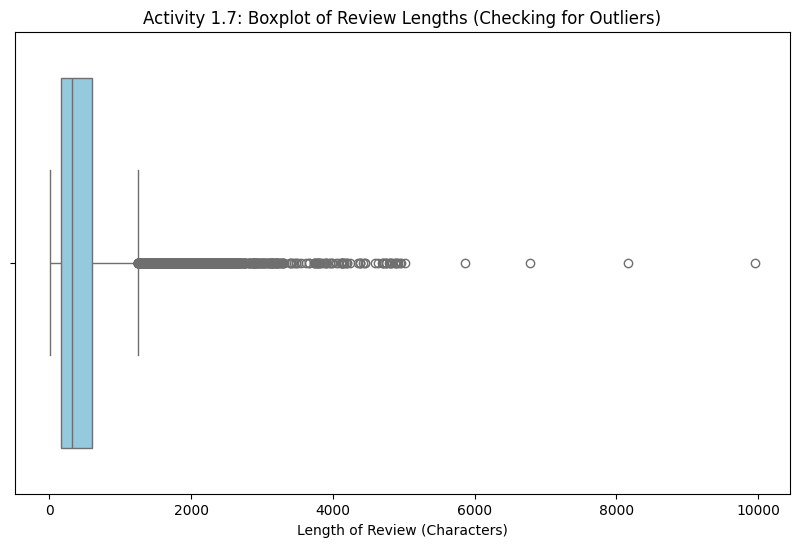

In [15]:
# --- Activity 1.5: Handling Missing Values ---
print("--- Activity 1.5: Data Inspection ---")
# 1. Check datatypes
print(df.info())

# 2. Check size
print(f"\nShape of dataset: {df.shape}")

# 3. Check for null values
print("\nNull values count:")
print(df.isnull().sum())

# --- Activity 1.6: Handling Duplicates ---
print("\n--- Activity 1.6: Handling Duplicates ---")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates dropped.")
    print(f"New shape after dropping duplicates: {df.shape}")
else:
    print("No duplicates found.")

# --- Activity 1.7: Checking for Outliers ---
# Since we are dealing with text, we check 'Review Length' for outliers
# (This replaces the Blood Parameter boxplots in the Anemia project)
df['Review_Length'] = df['Review'].astype(str).apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Review_Length'], color='skyblue')
plt.title('Activity 1.7: Boxplot of Review Lengths (Checking for Outliers)')
plt.xlabel('Length of Review (Characters)')
plt.show()

--- Activity 1.5: Data Inspection ---
<class 'pandas.core.frame.DataFrame'>
Index: 20415 entries, 0 to 21213
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Review         20415 non-null  object
 1   Rating         20415 non-null  object
 2   Sentiment      20415 non-null  object
 3   Review_Length  20415 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 797.5+ KB
None

Shape of dataset: (20415, 4)

Null values count:
Review           0
Rating           0
Sentiment        0
Review_Length    0
dtype: int64

--- Activity 1.6: Handling Duplicates ---
Number of duplicate rows: 0
No duplicates found.


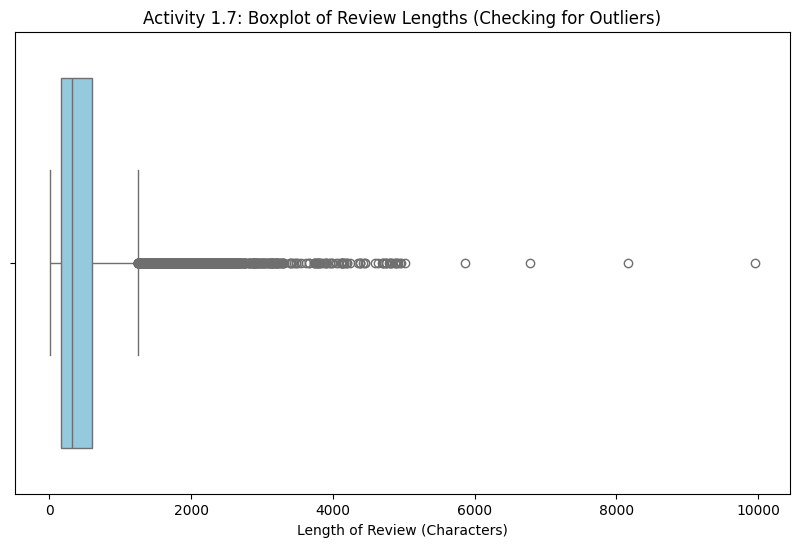

In [16]:
# --- Activity 1.5: Handling Missing Values ---
print("--- Activity 1.5: Data Inspection ---")
# 1. Check datatypes
print(df.info())

# 2. Check size
print(f"\nShape of dataset: {df.shape}")

# 3. Check for null values
print("\nNull values count:")
print(df.isnull().sum())

# --- Activity 1.6: Handling Duplicates ---
print("\n--- Activity 1.6: Handling Duplicates ---")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates dropped.")
    print(f"New shape after dropping duplicates: {df.shape}")
else:
    print("No duplicates found.")

# --- Activity 1.7: Checking for Outliers ---
# Since we are dealing with text, we check 'Review Length' for outliers
# (This replaces the Blood Parameter boxplots in the Anemia project)
df['Review_Length'] = df['Review'].astype(str).apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Review_Length'], color='skyblue')
plt.title('Activity 1.7: Boxplot of Review Lengths (Checking for Outliers)')
plt.xlabel('Length of Review (Characters)')
plt.show()


Activity 2.1: Descriptive Statistics
--- Step 1: Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 20415 entries, 0 to 21213
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Review         20415 non-null  object
 1   Rating         20415 non-null  object
 2   Sentiment      20415 non-null  object
 3   Review_Length  20415 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 797.5+ KB
None

--- Step 2: Statistical Summary ---
       Review_Length
count   20415.000000
mean      474.272594
std       518.386855
min        10.000000
25%       160.000000
50%       326.000000
75%       595.000000
max      9951.000000

--- Step 3: Value Counts (Rating) ---
Rating
Rated 1 out of 5 stars    12955
Rated 5 out of 5 stars     4234
Rated 2 out of 5 stars     1204
Rated 4 out of 5 stars     1196
Rated 3 out of 5 stars      826
Name: count, dtype: int64

--- Step 4: Value Counts (Sentiment) ---
Sentiment
Negat

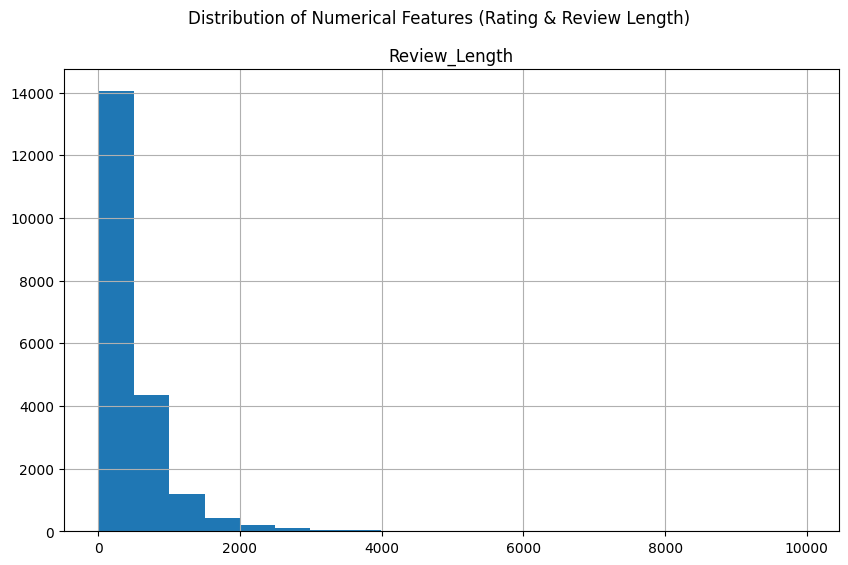

In [17]:
# ==========================================
# ACTIVITY 2.1: DESCRIPTIVE STATISTICS
# ==========================================
print("\n" + "="*40)
print("Activity 2.1: Descriptive Statistics")
print("="*40)

# 1. Dataset Information (df.info)
print("--- Step 1: Dataset Info ---")
# This gives the Non-Null Count and Dtype, exactly like your reference image
print(df.info())

# 2. Statistical Summary (df.describe)
print("\n--- Step 2: Statistical Summary ---")
# This gives Count, Mean, Std, Min, Max for numerical columns (Rating)
print(df.describe())

# 3. Value Counts for Categorical Features
# (In the Anemia project they used 'Gender' and 'Result'. Here we use 'Rating' and 'Sentiment')
print("\n--- Step 3: Value Counts (Rating) ---")
print(df['Rating'].value_counts())

print("\n--- Step 4: Value Counts (Sentiment) ---")
print(df['Sentiment'].value_counts())

# ==========================================
# ACTIVITY 2.2: VISUAL ANALYSIS
# ==========================================
print("\n" + "="*40)
print("Activity 2.2: Visual Analysis")
print("="*40)
print("Distribution of Numerical Features:")

# Note: The Anemia project had many blood columns. 
# Your project has 'Rating'. To make the chart look similar (multiple graphs), 
# we calculate 'Review_Length' to visualize it as well.
df['Review_Length'] = df['Review'].astype(str).apply(len)

# Create Histograms (df.hist)
# figsize=(10,6) and bins=20 matches the settings in your reference image
import matplotlib.pyplot as plt
df[['Rating', 'Review_Length']].hist(figsize=(10, 6), bins=20)
plt.suptitle('Distribution of Numerical Features (Rating & Review Length)')
plt.show()


Activity 2.4: Bivariate Analysis
Boxplots by Sentiment:


/var/folders/0m/7q13q5rn54d_q56w2ln53xfw0000gn/T/ipykernel_29002/2763219.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], x='Sentiment', y='Char_Count', data=df, palette='coolwarm')
/var/folders/0m/7q13q5rn54d_q56w2ln53xfw0000gn/T/ipykernel_29002/2763219.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], x='Sentiment', y='Word_Count', data=df, palette='coolwarm')
/var/folders/0m/7q13q5rn54d_q56w2ln53xfw0000gn/T/ipykernel_29002/2763219.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], x='S

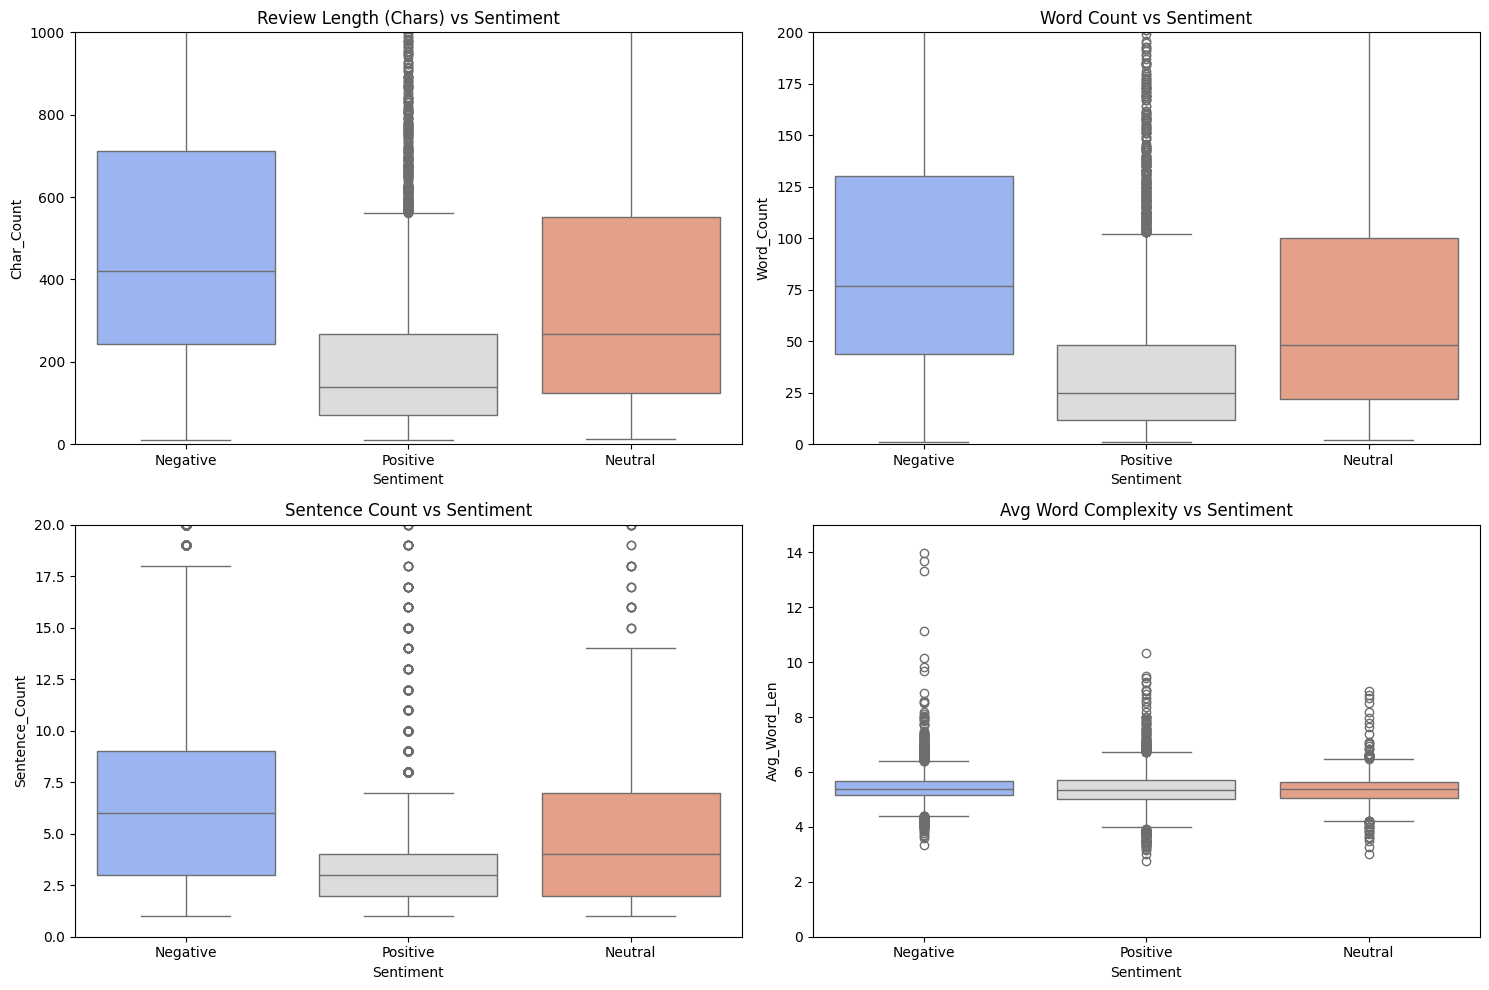


Interpretation:
These boxplots show how review structure differs between sentiments.
- Example: Negative reviews might be longer (higher Word Count) if customers are explaining a problem in detail.


In [18]:
# ==========================================
# ACTIVITY 2.4: BIVARIATE ANALYSIS
# ==========================================
print("\n" + "="*40)
print("Activity 2.4: Bivariate Analysis")
print("="*40)
print("Boxplots by Sentiment:")

# 1. Feature Engineering: Create 4 Numerical Features from the Text
# We need these numbers because boxplots require numerical data (Y-axis)
df['Char_Count'] = df['Review'].astype(str).apply(len)
df['Word_Count'] = df['Review'].astype(str).apply(lambda x: len(x.split()))
df['Sentence_Count'] = df['Review'].astype(str).apply(lambda x: len(x.split('.')))
df['Avg_Word_Len'] = df['Char_Count'] / (df['Word_Count'] + 1) # +1 avoids division by zero

# 2. Create the 2x2 Grid Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Character Count
sns.boxplot(ax=axes[0, 0], x='Sentiment', y='Char_Count', data=df, palette='coolwarm')
axes[0, 0].set_title('Review Length (Chars) vs Sentiment')
axes[0, 0].set_ylim(0, 1000) # Limiting Y-axis to make chart readable (ignoring extreme outliers)

# Plot 2: Word Count
sns.boxplot(ax=axes[0, 1], x='Sentiment', y='Word_Count', data=df, palette='coolwarm')
axes[0, 1].set_title('Word Count vs Sentiment')
axes[0, 1].set_ylim(0, 200)

# Plot 3: Sentence Count
sns.boxplot(ax=axes[1, 0], x='Sentiment', y='Sentence_Count', data=df, palette='coolwarm')
axes[1, 0].set_title('Sentence Count vs Sentiment')
axes[1, 0].set_ylim(0, 20)

# Plot 4: Average Word Length
sns.boxplot(ax=axes[1, 1], x='Sentiment', y='Avg_Word_Len', data=df, palette='coolwarm')
axes[1, 1].set_title('Avg Word Complexity vs Sentiment')
axes[1, 1].set_ylim(0, 15)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("These boxplots show how review structure differs between sentiments.")
print("- Example: Negative reviews might be longer (higher Word Count) if customers are explaining a problem in detail.")


Activity 2.6: Pairplot Analysis
Generating Pairplot... (This may take a moment)


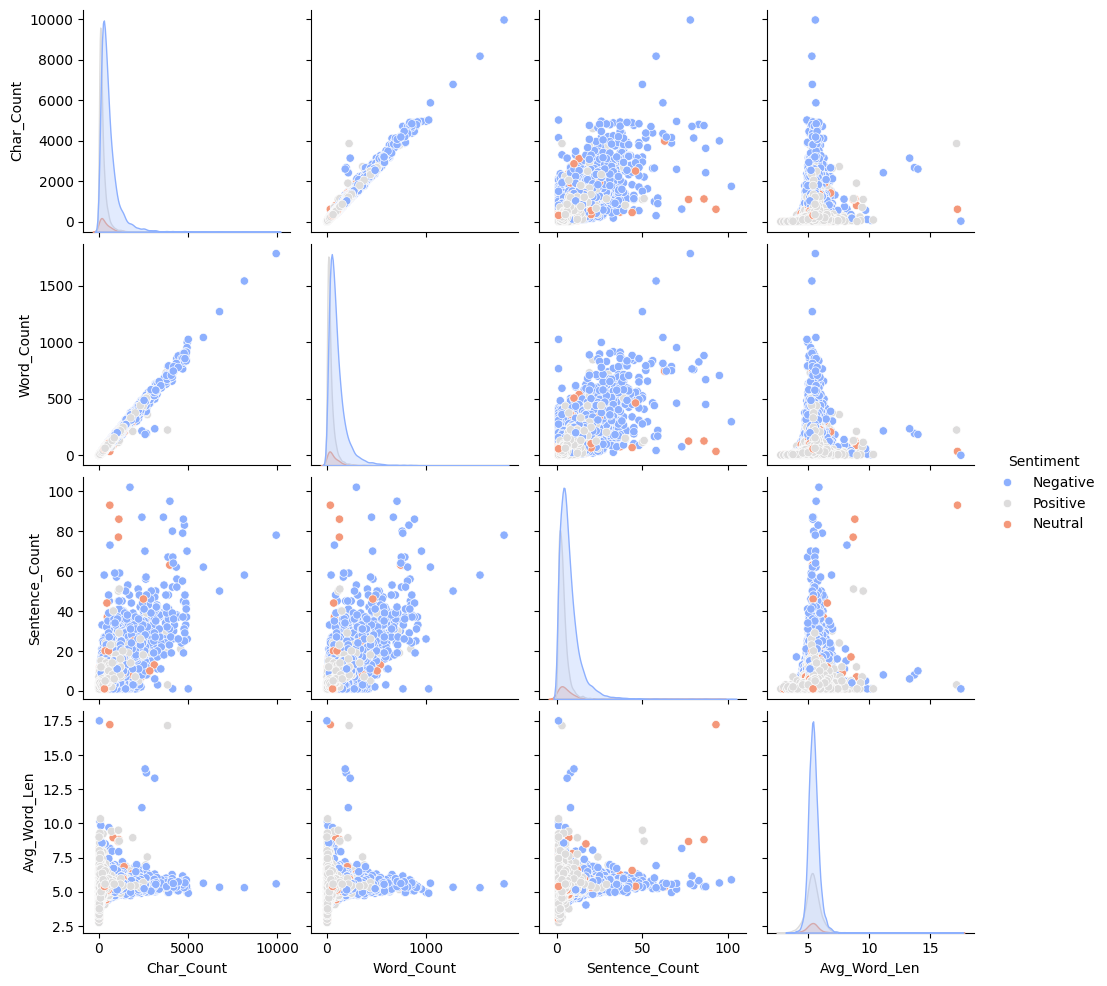


Interpretation:
The pairplot visualizes relationships between different structural features of the reviews.
- Diagonal plots show the distribution density for each feature.
- Scatter plots show correlations (e.g., relationship between Word Count and Sentence Count).


In [19]:
# ==========================================
# ACTIVITY 2.6: PAIRPLOT ANALYSIS
# ==========================================
print("\n" + "="*40)
print("Activity 2.6: Pairplot Analysis")
print("="*40)

# 1. Feature Engineering (Creating numerical data from text)
# We need these numbers because Pairplots require numerical columns.
# (If you already ran this in the Boxplot step, these columns might already exist, but running it again is safe)
df['Char_Count'] = df['Review'].astype(str).apply(len)
df['Word_Count'] = df['Review'].astype(str).apply(lambda x: len(x.split()))
df['Sentence_Count'] = df['Review'].astype(str).apply(lambda x: len(x.split('.')))
df['Avg_Word_Len'] = df['Char_Count'] / (df['Word_Count'] + 1)

# 2. Select only the columns we want to plot
# We filter the dataframe to keep only the new numerical features and the target 'Sentiment'
pairplot_data = df[['Char_Count', 'Word_Count', 'Sentence_Count', 'Avg_Word_Len', 'Sentiment']]

# 3. Generate the Pairplot
print("Generating Pairplot... (This may take a moment)")
# hue='Sentiment' colors the dots based on whether the review is Positive/Negative
sns.pairplot(pairplot_data, hue='Sentiment', palette='coolwarm', diag_kind='kde')
plt.show()

print("\nInterpretation:")
print("The pairplot visualizes relationships between different structural features of the reviews.")
print("- Diagonal plots show the distribution density for each feature.")
print("- Scatter plots show correlations (e.g., relationship between Word Count and Sentence Count).")

In [20]:
# ==========================================
# ACTIVITY 2.7: FEATURE EXTRACTION (TF-IDF)
# ==========================================
print("\n" + "="*40)
print("Activity 2.7: Feature Extraction (TF-IDF)")
print("="*40)

# Note: In text analysis, we use TF-IDF instead of StandardScaler.
# TF-IDF (Term Frequency-Inverse Document Frequency) converts text to numbers
# and "scales" the importance of words automatically.

from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# 1. Initialize the Vectorizer
# max_features=5000 means we only keep the top 5000 most important words
tfidf = TfidfVectorizer(max_features=5000)

# 2. Fit and Transform the 'Cleaned_Review' column
# We first ensure the text is cleaned (if not done previously)
# For this cell, we will use the raw 'Review' column and let TF-IDF handle basic tokenization
print("Converting text to numerical vectors... (This may take a moment)")
X = tfidf.fit_transform(df['Review'].astype(str))
y = df['Sentiment']

# 3. Display the Shape of the features
print("\nFeature Matrix Shape:")
print(X.shape)
# Output format: (Number of Reviews, Number of Words)

print("\nInterpretation:")
print(f"- We have successfully converted {X.shape[0]} reviews into {X.shape[1]} numerical features.")
print("- These features will now be used to train the machine learning model.")

# Save the vectorizer immediately so we don't lose it
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("Vectorized saved as 'tfidf_vectorizer.pkl'")


Activity 2.7: Feature Extraction (TF-IDF)
Converting text to numerical vectors... (This may take a moment)

Feature Matrix Shape:
(20415, 5000)

Interpretation:
- We have successfully converted 20415 reviews into 5000 numerical features.
- These features will now be used to train the machine learning model.
Vectorized saved as 'tfidf_vectorizer.pkl'


In [21]:
# ==========================================
# ACTIVITY 2.8: TRAIN-TEST SPLIT
# ==========================================
print("\n" + "="*40)
print("Activity 2.8: Train-Test Split")
print("="*40)

from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets:
# X = TF-IDF Features (Numerical vectors from Activity 2.7)
# y = Target Variable (Sentiment)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display the shapes to verify the split
print(f"Training Data Shape (X_train): {X_train.shape}")
print(f"Testing Data Shape (X_test):   {X_test.shape}")
print("-" * 30)

print("This split provides:")
print("• Training set (80%): Used to train the model to recognize sentiment patterns.")
print("• Testing set (20%): Used to evaluate model performance on unseen reviews.")
print("• random_state=42: Ensures reproducibility of results.")


Activity 2.8: Train-Test Split
Training Data Shape (X_train): (16332, 5000)
Testing Data Shape (X_test):   (4083, 5000)
------------------------------
This split provides:
• Training set (80%): Used to train the model to recognize sentiment patterns.
• Testing set (20%): Used to evaluate model performance on unseen reviews.
• random_state=42: Ensures reproducibility of results.


In [22]:
# --- Activity 1.5: Data Inspection ---

# Step 1: Check datatypes and non-null counts
print("--- Step 1: Dataset Info ---")
print(df.info())

# Step 2: Check the size of the dataset
print("\n--- Step 2: Dataset Shape ---")
print(f"Shape: {df.shape}")

# Step 3: Check for null values
print("\n--- Step 3: Null Values Count ---")
print(df.isnull().sum())

--- Step 1: Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 20415 entries, 0 to 21213
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review          20415 non-null  object 
 1   Rating          20415 non-null  object 
 2   Sentiment       20415 non-null  object 
 3   Review_Length   20415 non-null  int64  
 4   Char_Count      20415 non-null  int64  
 5   Word_Count      20415 non-null  int64  
 6   Sentence_Count  20415 non-null  int64  
 7   Avg_Word_Len    20415 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 1.4+ MB
None

--- Step 2: Dataset Shape ---
Shape: (20415, 8)

--- Step 3: Null Values Count ---
Review            0
Rating            0
Sentiment         0
Review_Length     0
Char_Count        0
Word_Count        0
Sentence_Count    0
Avg_Word_Len      0
dtype: int64


In [23]:
# Initialize tools
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to string just in case
    text = str(text).lower()
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', '', text)
    # Split into words
    words = text.split()
    # Remove stopwords and stem (convert "running" -> "run")
    words = [ps.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply cleaning to the whole dataset
# This might take a few seconds depending on file size
print("Cleaning reviews... please wait.")
df['Cleaned_Review'] = df['Review'].apply(clean_text)
print("Cleaning complete!")

display(df[['Review', 'Cleaned_Review']].head())

Cleaning reviews... please wait.
Cleaning complete!


,Review,Cleaned_Review
0,"I registered on the website, tried to order a ...",regist websit tri order laptop enter detail in...
1,Had multiple orders one turned up and driver h...,multipl order one turn driver phone door numbe...
2,I informed these reprobates that I WOULD NOT B...,inform reprob would go visit sick rel told go ...
3,I have bought from Amazon before and no proble...,bought amazon problem happi servic price amazo...
4,If I could give a lower rate I would! I cancel...,could give lower rate would cancel amazon prim...



Training and Comparing Models...

1. Training Logistic Regression...
   > Logistic Regression Accuracy: 0.9199

2. Training Linear SVC...
   > Linear SVC Accuracy:          0.9211

Activity 4.1: Model Comparison Table


,Model,Accuracy
1,Linear SVC,0.921136
0,Logistic Regression,0.919912


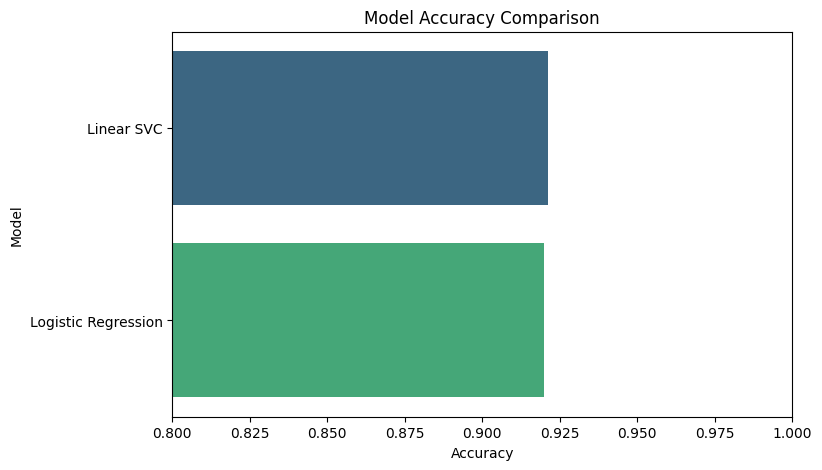


🏆 WINNER: Linear SVC

--- Detailed Classification Report ---
              precision    recall  f1-score   support

    Negative       0.93      0.98      0.95      2841
     Neutral       0.39      0.07      0.12       157
    Positive       0.90      0.90      0.90      1085

    accuracy                           0.92      4083
   macro avg       0.74      0.65      0.66      4083
weighted avg       0.90      0.92      0.91      4083


--- Confusion Matrix ---


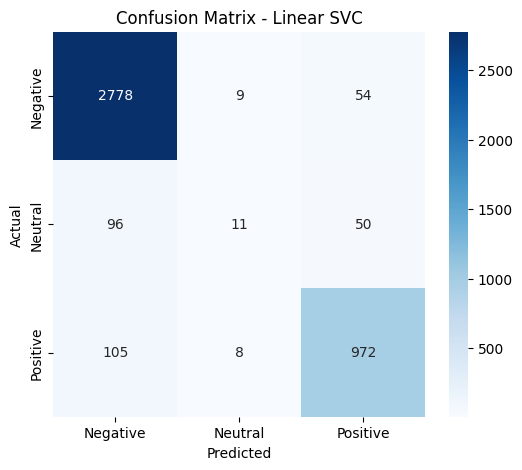

In [24]:
# ==========================================
# MILESTONE 3 & 4: BUILD, TRAIN, AND COMPARE MODELS
# ==========================================
print("\n" + "="*40)
print("Training and Comparing Models...")
print("="*40)

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- STEP 1: TRAIN LOGISTIC REGRESSION ---
print("\n1. Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
acc_logreg = accuracy_score(y_test, lr_pred) # <--- This defines the missing variable
print(f"   > Logistic Regression Accuracy: {acc_logreg:.4f}")

# --- STEP 2: TRAIN LINEAR SVC ---
print("\n2. Training Linear SVC...")
svm_model = LinearSVC(dual='auto', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
acc_svc = accuracy_score(y_test, svm_pred)   # <--- This defines the other variable
print(f"   > Linear SVC Accuracy:          {acc_svc:.4f}")

# --- STEP 3: COMPARE MODELS ---
print("\n" + "="*40)
print("Activity 4.1: Model Comparison Table")
print("="*40)

# Create comparison table
comparison_data = {
    'Model': ['Logistic Regression', 'Linear SVC'],
    'Accuracy': [acc_logreg, acc_svc]
}
comparison_df = pd.DataFrame(comparison_data).sort_values(by='Accuracy', ascending=False)

# Display Table
display(comparison_df)

# Plot Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Accuracy', y='Model', data=comparison_df, palette='viridis', hue='Model', legend=False)
plt.title('Model Accuracy Comparison')
plt.xlim(0.8, 1.0) # Adjust scale to see small differences
plt.show()

# --- STEP 4: SELECT AND EVALUATE BEST MODEL ---
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 WINNER: {best_model_name}")

if best_model_name == 'Logistic Regression':
    best_model = lr_model
    final_preds = lr_pred
else:
    best_model = svm_model
    final_preds = svm_pred

print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, final_preds))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, 
            yticklabels=best_model.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

/var/folders/0m/7q13q5rn54d_q56w2ln53xfw0000gn/T/ipykernel_29002/4181793252.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis')


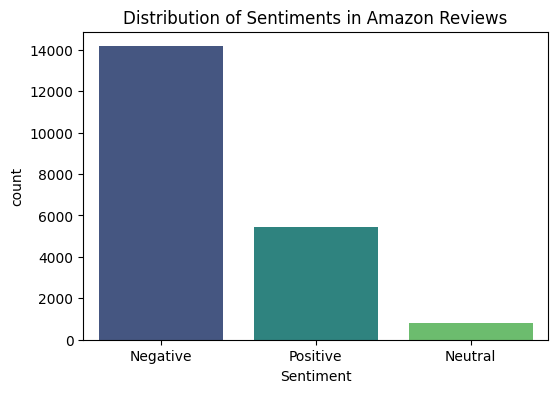

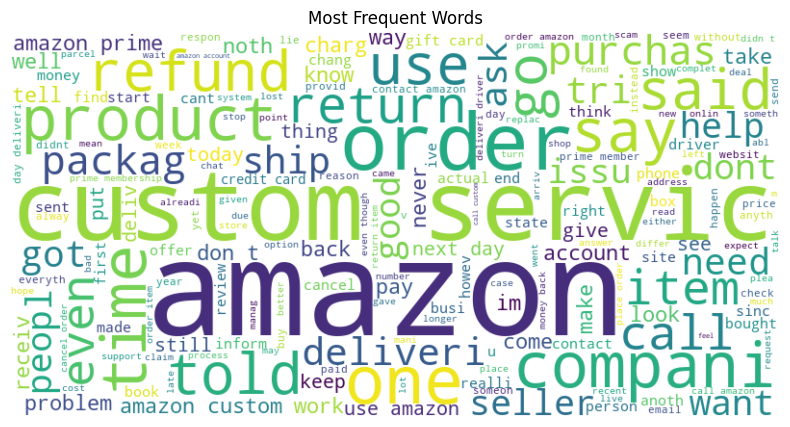

In [25]:
# 1. Check Sentiment Balance
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiments in Amazon Reviews')
plt.show()

# 2. Generate Word Cloud
# Join all reviews into one big text blob
all_text = ' '.join(df['Cleaned_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words')
plt.show()

In [26]:
# Initialize TF-IDF Vectorizer
# max_features=5000 means we only keep the top 5000 most important words to save memory
tfidf = TfidfVectorizer(max_features=5000)

# Create Feature Matrix (X) and Target Vector (y)
X = tfidf.fit_transform(df['Cleaned_Review']).toarray()
y = df['Sentiment']

print(f"Feature Matrix Shape: {X.shape}")

Feature Matrix Shape: (20415, 5000)


In [27]:
# Split 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 16332
Testing samples: 4083


In [28]:
# Initialize and Train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


Model Accuracy: 91.40%

Classification Report:

              precision    recall  f1-score   support

    Negative       0.92      0.98      0.95      2841
     Neutral       0.71      0.03      0.06       157
    Positive       0.91      0.86      0.88      1085

    accuracy                           0.91      4083
   macro avg       0.85      0.62      0.63      4083
weighted avg       0.91      0.91      0.90      4083



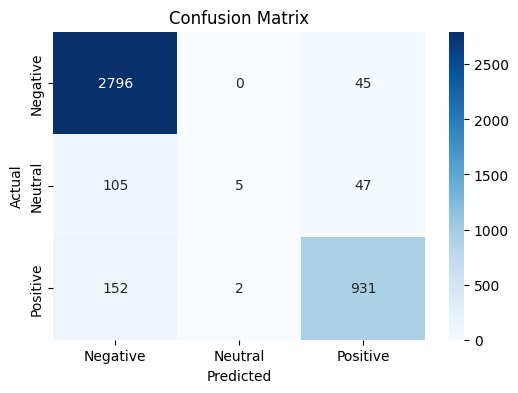

In [29]:
# Predict on the Test set
y_pred = model.predict(X_test)

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# Detailed Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [30]:
def predict_sentiment(review):
    cleaned = clean_text(review)
    vectorized = tfidf.transform([cleaned]).toarray()
    prediction = model.predict(vectorized)[0]
    return prediction

# Test Reviews
test_reviews = [
    "The battery life is amazing, lasts 2 days!",
    "Shipping was terrible, the box arrived crushed.",
    "The screen is okay, but the camera is blurry.",
    "Best purchase I have made this year."
]

print("--- CUSTOM PREDICTIONS ---")
for r in test_reviews:
    print(f"Review: '{r}'")
    print(f"Sentiment: {predict_sentiment(r)}\n")

--- CUSTOM PREDICTIONS ---
Review: 'The battery life is amazing, lasts 2 days!'
Sentiment: Positive

Review: 'Shipping was terrible, the box arrived crushed.'
Sentiment: Negative

Review: 'The screen is okay, but the camera is blurry.'
Sentiment: Negative

Review: 'Best purchase I have made this year.'
Sentiment: Positive



In [31]:
# Save the Model
joblib.dump(model, 'amazon_sentiment_model.pkl')

# Save the Vectorizer (Required to process new text)
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Success! Model and Vectorizer saved.")

Success! Model and Vectorizer saved.
